In [7]:
!python -m pip install "../."

Processing c:\users\danii\program\python\project\imgdoc
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imgdoc: filename=imgdoc-0.0.3-py3-none-any.whl size=12306 sha256=864440f8eaaf2f206cc9397ac99908b2353b72841b52eb9879ec9fec5b84e7e5
  Stored in directory: C:\Users\danii\AppData\Local\Temp\pip-ephem-wheel-cache-vw7b4nqu\wheels\b8\e3\4a\f1f494124c2259921bd58533df69bb605814dcc87a7223eb4d
Successfully built imgdoc
  Attempting uninstall: imgdoc
    Found existing installation: imgdoc 0.0.3
    Uninstalling imgdoc-0.0.3:
      Successfully uninstalled imgdoc-0.0.3


In [1]:
import pytesseract
from img_doc.extractors.word_extractors import BaseWordExtractor
from img_doc.data_structures import Word
import numpy as np
from typing import List

class TesseractWordExtractor(BaseWordExtractor):
    def extract_from_img(self, img: np) -> List[Word]:
        tesseract_bboxes = pytesseract.image_to_data(
            config="-l rus",
            image=img,
            output_type=pytesseract.Output.DICT)
        word_list = []
        for index_bbox, level in enumerate(tesseract_bboxes["level"]):
            if level == 5:
                word = Word(text = tesseract_bboxes["text"][index_bbox])
                word.set_point_and_size({
                    "x_top_left":tesseract_bboxes["left"][index_bbox],
                    "y_top_left":tesseract_bboxes["top"][index_bbox],
                    "width":tesseract_bboxes["width"][index_bbox],
                    "height": tesseract_bboxes["height"][index_bbox],
                })
                word_list.append(word)
        return word_list

In [8]:
from img_doc.data_structures import Image
import os

image = Image()
image.set_img_from_path(os.path.join("img", "2.jpg"))

word_ext = TesseractWordExtractor()
words = word_ext.extract_from_img(image.img)

In [9]:
from img_doc.extractors.block_extractors.block_extractor_from_word import KMeanBlockExtractor
kmeanext = KMeanBlockExtractor()


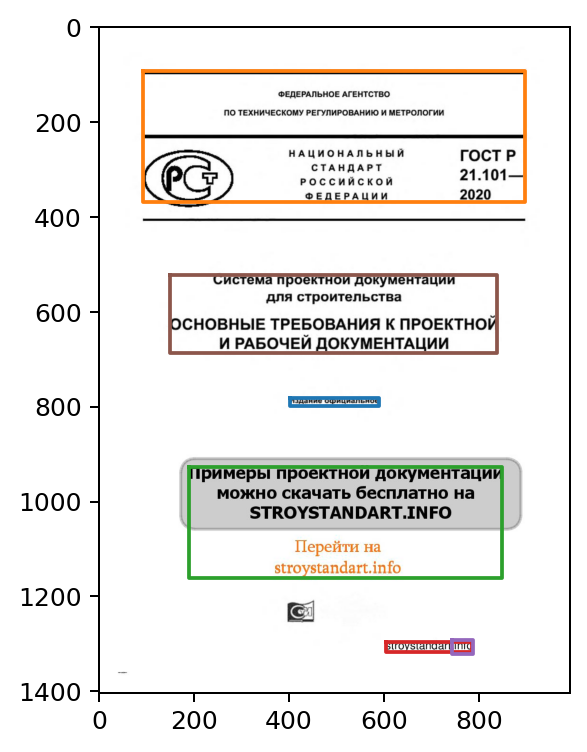

In [10]:
import matplotlib.pyplot as plt

color = ["g", "y", "k", "r"]
plt.figure(dpi=180)
plt.imshow(image.img)

blocks = kmeanext.extract_from_word(words)
for block in blocks:
    x0 = block.segment.x_top_left
    y0 = block.segment.y_top_left
    x1 = block.segment.x_bottom_right
    y1 = block.segment.y_bottom_right
    plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0])

In [5]:
def intersection(new_block, block):
    seg = block.segment
    points1 = [(seg.x_top_left, seg.y_top_left), (seg.x_top_left, seg.y_bottom_right), 
              (seg.x_bottom_right, seg.y_top_left), (seg.x_bottom_right, seg.y_bottom_right)]
    
    new_seg = new_block.segment
    
    for p in points1:
        if (new_seg.x_top_left < p[0]) and (new_seg.x_bottom_right > p[0]) and \
           (new_seg.y_top_left < p[1]) and (new_seg.y_bottom_right > p[1]):
            return True
    p = (new_seg.x_top_left, new_seg.y_top_left)
    if (seg.x_top_left < p[0]) and (seg.x_bottom_right > p[0]) and \
       (seg.y_top_left < p[1]) and (seg.y_bottom_right > p[1]):
            return True
        
    return False

def add_block_in_block(new_block, block):
    new_block.words += block.words
    new_block.rows += block.rows
    
    c1 = new_block.segment.get_segment_2p()
    c2 = block.segment.get_segment_2p()
    
    new_block.segment.set_segment_2p({
        "x_top_left": min(c1["x_top_left"], c2["x_top_left"]),
        "x_bottom_right": max(c1["x_bottom_right"], c2["x_bottom_right"]),
        "y_top_left": min(c1["y_top_left"], c2["y_top_left"]),
        "y_bottom_right": max(c1["y_bottom_right"], c2["y_bottom_right"]),
    })
    

def add_block_in_new_list(new_blocks, block):
    for new_block in new_blocks:
        if intersection(new_block, block):
            add_block_in_block(new_block, block)
            return
    new_blocks.append(block)
    
    
new_blocks = []

for block in blocks:
    add_block_in_new_list(new_blocks, block)
    
            

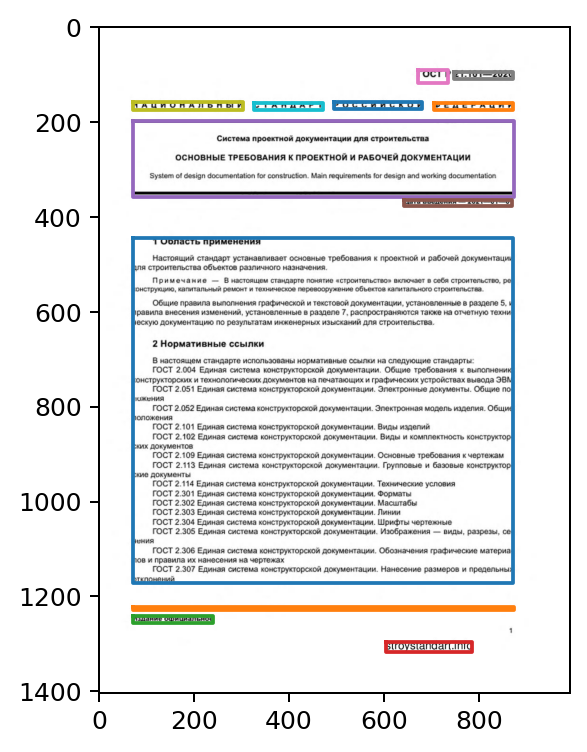

In [6]:
import matplotlib.pyplot as plt

color = ["g", "y", "k", "r"]
plt.figure(dpi=180)
plt.imshow(image.img)


for block in new_blocks:
    x0 = block.segment.x_top_left
    y0 = block.segment.y_top_left
    x1 = block.segment.x_bottom_right
    y1 = block.segment.y_bottom_right
    plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0])